In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm as cmplt

import sys
sys.path.insert(0, '../../opticalforces')

from beam import ScalarFrozenWave
from particle import SphericalParticle

fig_num = 0

In [9]:
L = 5e-3

def batman_func(z):
    ls = [l for l in (-7.03, -3, -1.05, -0.7, -0.48, 0.48, 0.7, 1.05, 3, 7.03)]
    
    l1, l2, l3, l4, l5, l6, l7, l8, l9, l10 = ls

    z = -z*20/L if z > 0 else z*20/L
                
    if (l1 <= z and z <= l2):
        return -0.0025*z**4 - 0.0106*z**3 + 0.0442*z**2 + 0.4838*z + 3.7131
    elif l2 <= z and z <= l3:
        return 0.0892*z**4 + 0.1116*z**3 - 0.5099*z**2 - 0.6137*z + 1.2631
    elif l3 <= z and z <= l4:
        return 4.8*z + 6.36
    elif l4 <= z and z <= l5:
        return -3.1818*z + 0.7727
    elif l5 <= z and z <= l6:
        return 2.3
    else:
        return 0
        
vfw = ScalarFrozenWave(centered=True)
vfw.name = 'lip-const'
vfw.vacuum_wavelength = 632e-9
vfw.medium_refractive_index = 1
vfw.N = 55
vfw.L = L
vfw.Q = 0.99*vfw.wavenumber
vfw.reference_function = batman_func

print(vfw.beams[0].axicon_angle_degree, vfw.beams[2*55].axicon_angle_degree)

/home/arantespp/.local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


10.564854763077687 4.474613041417988


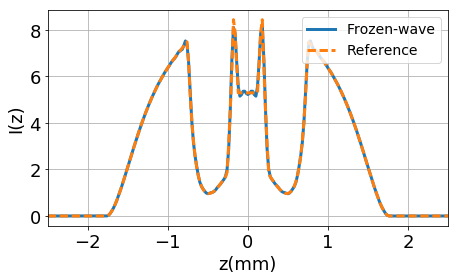

In [3]:
z = np.linspace(-L/2, L/2, 251)

fig_num += 1
plt.figure(fig_num, figsize=(4*1.618, 4))

plt.plot([z*1e3 for z in z], [vfw.intensity(0, 0, z) for z in z], lw=3, label='Frozen-wave')
plt.plot([z*1e3 for z in z], [vfw.reference_function(z)**2 for z in z], '--', lw=3, label='Reference')
plt.legend(fontsize=12, loc=1)
plt.xlim([-L/2*1e3, L/2*1e3])
plt.legend(fontsize=14, loc=1)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xlabel(r'z(mm)', fontsize=18)
plt.ylabel('I(z)', fontsize=18)
plt.grid()
plt.tight_layout()
plt.savefig('perfil-2D.png',  dpi=300)
plt.show()

### 3D plot

In [5]:
rho_max = 50e-6
z_max = L/2

rho = np.linspace(-rho_max, rho_max, 251)
z = np.linspace(-z_max, z_max, 251)
RHO, Z = np.meshgrid(rho, z)

vinty = np.vectorize(lambda rho, z: vfw.intensity(rho, 0, z, 'cylindrical'))

INTY = vinty(RHO, Z)

RHO = [rho*1e6 for rho in RHO]
Z = [z*1e3 for z in Z]

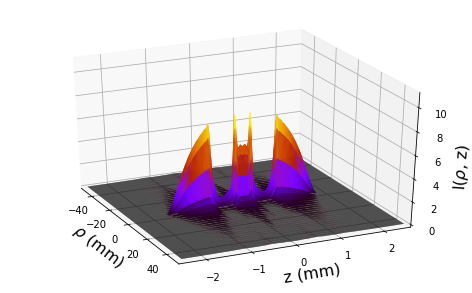

In [6]:
fig_num += 1
plt.figure(fig_num, figsize=(5*1.618, 5))
ax = plt.gca(projection='3d')

# https://matplotlib.org/examples/color/colormaps_reference.html
ax.plot_surface(RHO, Z, INTY, rcount=1000, ccount=1000, alpha=1, cmap=cmplt.gnuplot)
#cset = ax.contourf(RHO, Z, INTY, zdir='z', offset=0, cmap=cmplt.coolwarm)
#cset = ax.contourf(RHO, Z, INTY, zdir='x', offset=-Rmax, cmap=cmplt.coolwarm)
#cset = ax.contourf(RHO, Z, INTY, zdir='y', offset=Zmax, cmap=cmplt.coolwarm)

ax.set_xlabel(r'$\rho$ (mm)', fontsize=16)
ax.set_xlim(-rho_max*1e6, rho_max*1e6)
ax.set_ylabel(r'z (mm)', fontsize=16)
ax.set_ylim(-z_max*1e3, z_max*1e3)
ax.set_zlabel(r'I($\rho$, z)', fontsize=16)
ax.set_zlim(0, 11)

ax.view_init(elev=30, azim=-25)

plt.savefig('perfil-3D.png',  dpi=300)
plt.show()

### Longitudinal forces

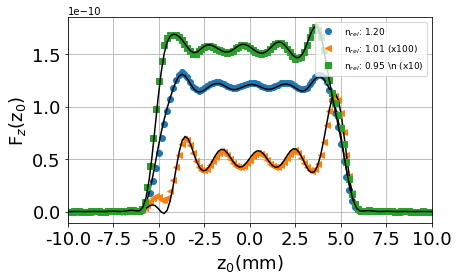

In [13]:
# LIP Frozen Wave longitudinal forces
fig_num += 1
plt.figure(fig_num, figsize=(4*1.618, 4))

emtdata = pd.read_csv('EMTheoryData-lip-const-fw.csv', index_col=0)
factor = 11.0

ptc = SphericalParticle()
ptc.radius = 20e-6
ptc.medium_refractive_index = 1.33

beam_pos = (0, 0, 0)

paramx = {'param': 'beam_pos_z',
          'start': -2*L/10,
          'stop': 2*L/10,
          'num': 80,}

ptc.refractive_index = 1.2*1.33
X1, F1 = ptc.geo_opt_force(vfw, beam_pos, force_dir='fz', paramx=paramx)
label = r'n$_{rel}$: %.2f' % (ptc.refractive_index/1.33)
plt.plot(X1, [1*f for f in F1], 'o', label=label)
plt.plot(emtdata.index, [data*factor for data in emtdata['120']], color='k')

ptc.refractive_index = 1.01*1.33
X2, F2 = ptc.geo_opt_force(vfw, beam_pos, force_dir='fz', paramx=paramx)
label = r'n$_{rel}$: %.2f (x100)' % (ptc.refractive_index/1.33)
plt.plot(X2, [100*f for f in F2], '<', label=label)
plt.plot(emtdata.index, [data*factor*100 for data in emtdata['101']], color='k')

ptc.refractive_index = 0.95*1.33
X3, F3 = ptc.geo_opt_force(vfw, beam_pos, force_dir='fz', paramx=paramx)
label = r'n$_{rel}$: %.2f (x10)' % (ptc.refractive_index/1.33)
plt.plot(X3, [10*f for f in F3], 's', label=label)
plt.plot(emtdata.index, [data*factor*10 for data in emtdata['095']], color='k')

plt.xlim([-0.2*L, 0.2*L])

xlocs, xlabs = plt.xticks()
plt.xticks(xlocs, [xl*1e3 for xl in xlocs])

plt.legend(fontsize=9, loc=1)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xlabel(r'z$_0$(mm)', fontsize=18)
plt.ylabel(r'F$_z$(z$_0$)', fontsize=18)
plt.grid()
plt.tight_layout()
plt.savefig('LIP-const-longit-forces.png',  dpi=300)

plt.show()